In [19]:
import trimesh
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import json


class MeshDataset(Dataset):
    def __init__(self, mesh_dir, proj_dir, max_vertices=17664, max_points=20000, transform=None):
        self.mesh_dir = mesh_dir
        self.proj_dir = proj_dir
        self.max_vertices = max_vertices
        self.max_points = max_points
        self.transform = transform
        self.mesh_files = [f for f in os.listdir(mesh_dir) if f.endswith('.off')]
        self.proj_files = [f for f in os.listdir(proj_dir) if f.endswith('.json')]

    def __len__(self):
        return len(self.mesh_files)
    
    def __getitem__(self, idx):
        mesh_file = self.mesh_files[idx]
        proj_file = mesh_file.replace('.off','.json')

        mesh_path = os.path.join(self.mesh_dir, mesh_file)
        proj_path = os.path.join(self.proj_dir, proj_file)
        
        # Load mesh
        mesh = trimesh.load(mesh_path)
        vertices = np.array(mesh.vertices, dtype=np.float32)

        # Pad or truncate vertices to ensure consistent tensor size
        if vertices.shape[0] > self.max_vertices:
            vertices = vertices[:self.max_vertices]
        else:
            vertices = np.pad(vertices, ((0, self.max_vertices - vertices.shape[0]), (0, 0)), 'constant')
        
        vertices = torch.tensor(vertices)
        
        # Load x and y coordinates from JSON file
        with open(proj_path, 'r') as f:
            projection_data = json.load(f)
        x = np.array(projection_data['x'])
        y = np.array(projection_data['y'])
        
        # Convert x and y to a single tensor and pad/truncate to ensure consistent size
        xy = np.stack((x, y), axis=1)
        if xy.shape[0] > self.max_points:
            xy = xy[:self.max_points]
        else:
            xy = np.pad(xy, ((0, self.max_points - xy.shape[0]), (0, 0)), 'constant')
        
        xy = torch.tensor(xy, dtype=torch.float32)

        return vertices, xy


In [20]:
mesh_dir = '3D files'
img_dir = '2D projections'

# Transform for images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset and DataLoader
dataset = MeshDataset(mesh_dir, img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(dataset)
print(dataloader)


Vertices Type:  <class 'torch.Tensor'>
Vertices Shape:  torch.Size([17664, 3])
Vertices Average Value:  0.4547727406024933
XY Type:  <class 'torch.Tensor'>
XY Shape:  torch.Size([20000, 2])
XY Average Value:  1.1985844373703003


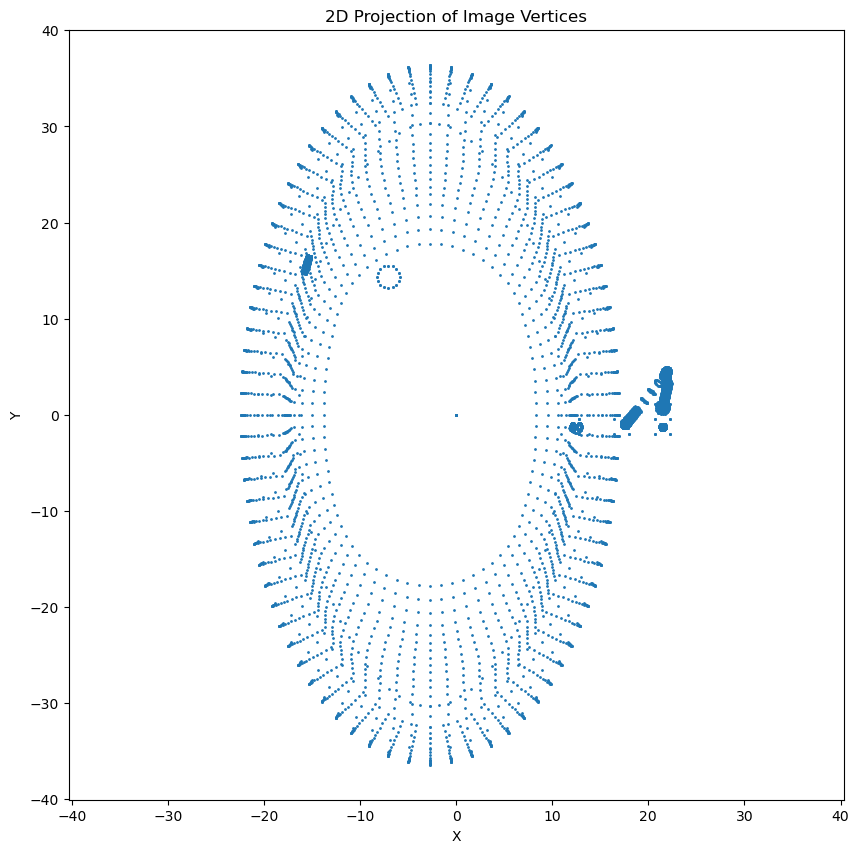

In [23]:
import matplotlib.pyplot as plt
from pythreejs import *
from IPython.display import display


data_iter = iter(dataloader)
vertices, xy = next(data_iter)

# Select the first element
vertices_example = vertices[0]
xy_example = xy[0]

# Print type, shape, and average value for the 3D shape (vertices) and the 2D projection (coordinates)
print("Vertices Type: ", type(vertices_example))
print("Vertices Shape: ", vertices_example.shape)
print("Vertices Average Value: ", vertices_example.mean().item())

print("XY Type: ", type(xy_example))
print("XY Shape: ", xy_example.shape)
print("XY Average Value: ", xy_example.mean().item())

# Extract x and y coordinates from xy tensor
x = xy_example[:, 0].numpy()
y = xy_example[:, 1].numpy()

# Plot the 2D scatter plot of x and y coordinates
plt.figure(figsize=(10, 10))
plt.scatter(x, y, s=1)
plt.title('2D Projection of Image Vertices')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()


In [25]:
vertices_np = vertices_example.numpy()
faces = np.arange(vertices_np.shape[0], dtype=np.uint32)

geometry = BufferGeometry(
    attributes={
        'position': BufferAttribute(vertices_np, normalized=False),
        'index': BufferAttribute(faces, normalized=False)
    }
)

material = MeshBasicMaterial(color='red', wireframe=True)
three_mesh = Mesh(geometry, material)

# Set up the scene and renderer
camera = PerspectiveCamera(position=[5, 5, 5], up=[0, 0, 1], aspect=1, fov=60)
camera.lookAt([0, 0, 0])

scene = Scene(children=[three_mesh, AmbientLight(color='#cccccc')])
renderer = Renderer(camera=camera, scene=scene, controls=[OrbitControls(controlling=camera)],
                    width=800, height=600)

# Display the rendered object
display(renderer)

Renderer(camera=PerspectiveCamera(fov=60.0, position=(5.0, 5.0, 5.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.…

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class MeshToImageNN(nn.Module):
    def __init__(self, max_vertices=17664, max_points=20000):
        super(MeshToImageNN, self).__init__()
        self.max_vertices = max_vertices
        self.max_points = max_points
        self.fc1 = nn.Linear(max_vertices * 3, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, max_points * 2)
        
    def forward(self, x):
        x = x.view(-1, self.max_vertices * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, self.max_points, 2)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MeshToImageNN().to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [28]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dataset and DataLoader setup
mesh_dir = '3D files'
proj_dir = '2D projections'

# Transform for images (if needed)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset and DataLoader
dataset = MeshDataset(mesh_dir, proj_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    for i, (vertices, xy) in enumerate(dataloader):
        vertices = vertices.to(device)
        xy = xy.to(device)
        optimizer.zero_grad()
        outputs = model(vertices)
        loss = criterion(outputs, xy)
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {loss.item():.4f}')

print('Training complete.')

# Save the model
torch.save(model.state_dict(), 'mesh_to_image_model.pth')

Epoch [1/1], Step [10/218], Loss: 24.4820
Epoch [1/1], Step [20/218], Loss: 24.9033
Epoch [1/1], Step [30/218], Loss: 322.7015
Epoch [1/1], Step [40/218], Loss: 5.9264
Epoch [1/1], Step [50/218], Loss: 178.7311
Epoch [1/1], Step [60/218], Loss: 462.1658
Epoch [1/1], Step [70/218], Loss: 7.6682
Epoch [1/1], Step [80/218], Loss: 12.5107
Epoch [1/1], Step [90/218], Loss: 281.4722
Epoch [1/1], Step [100/218], Loss: 9.7973
Epoch [1/1], Step [110/218], Loss: 27.1311
Epoch [1/1], Step [120/218], Loss: 31.4045
Epoch [1/1], Step [130/218], Loss: 42.9041
Epoch [1/1], Step [140/218], Loss: 16.4202
Epoch [1/1], Step [150/218], Loss: 5.8403
Epoch [1/1], Step [160/218], Loss: 7.4367
Epoch [1/1], Step [170/218], Loss: 5.7809
Epoch [1/1], Step [180/218], Loss: 285.5981
Epoch [1/1], Step [190/218], Loss: 12.9015
Epoch [1/1], Step [200/218], Loss: 15.0951
Epoch [1/1], Step [210/218], Loss: 15.3814
Training complete.


/var/folders/_j/7xf6n_ts231_sz96nsh2r8rm0000gn/T/ipykernel_58116/1091153369.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mesh_to_ima

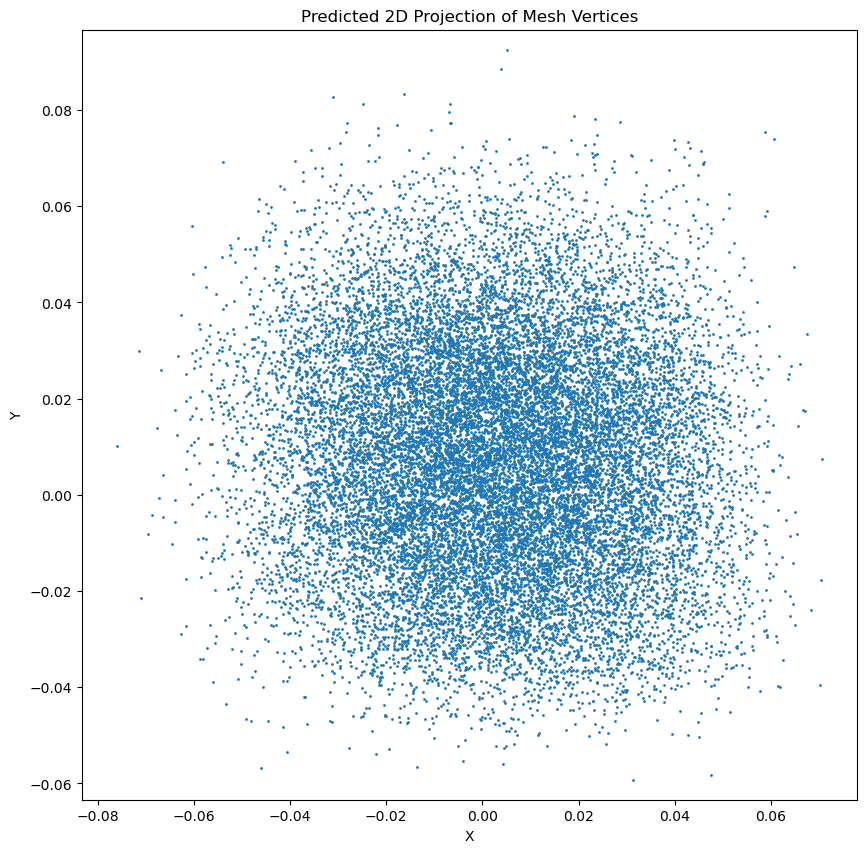

In [32]:
# Load the trained model for inference
device = "cpu"
model = MeshToImageNN().to(device)
model.load_state_dict(torch.load('mesh_to_image_model.pth'))
model.eval()

# Load the test mesh
test_mesh_path = 'Test Set/3D files/toilet_0443.off'
test_mesh = trimesh.load(test_mesh_path)
vertices = np.array(test_mesh.vertices, dtype=np.float32)

# Pad or truncate vertices to ensure consistent tensor size
max_vertices = 17664
if vertices.shape[0] > max_vertices:
    vertices = vertices[:max_vertices]
else:
    vertices = np.pad(vertices, ((0, max_vertices - vertices.shape[0]), (0, 0)), 'constant')

vertices = torch.tensor(vertices).unsqueeze(0)  # Add batch dimension

# Run inference
with torch.no_grad():
    predicted_xy = model(vertices).squeeze(0).numpy()

# Extract x and y coordinates from predicted_xy tensor
x_pred = predicted_xy[:, 0]
y_pred = predicted_xy[:, 1]

# Plot the 2D scatter plot of predicted x and y coordinates
plt.figure(figsize=(10, 10))
plt.scatter(x_pred, y_pred, s=1)
plt.title('Predicted 2D Projection of Mesh Vertices')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.savefig('predicted_2D_projection.png')  # Save the plot
plt.show()
